### A Walkthrough of DDIM inversion and Null-text inversion and Prompt-to-Prompt editing

In [1]:
# cd into the mmagic directory to make sure mmagic models work fine!!
%cd ../..

/mnt/wsl/PHYSICALDRIVE4/htr/mmagic


### Load Stable Diffusion from MMagic

In [2]:
from mmengine import MODELS, Config
from mmengine.registry import init_default_scope

init_default_scope('mmagic')

config = 'configs/stable_diffusion/stable-diffusion_ddim_denoisingunet.py'
config = Config.fromfile(config).copy()
# change the 'pretrained_model_path' if you have downloaded the weights manually
# config.model.unet.from_pretrained = '/path/to/your/stable-diffusion-v1-5'
# config.model.vae.from_pretrained = '/path/to/your/stable-diffusion-v1-5'

StableDiffuser = MODELS.build(config.model)
StableDiffuser = StableDiffuser.to('cuda')

/home/ssd2/priv/miniconda3/envs/mmagic/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


06/17 13:45:38 - mmengine - INFO - Creating runwayml/stable-diffusion-v1-5 by 'HuggingFace'


/mnt/wsl/PHYSICALDRIVE4/htr/mmagic/mmagic/models/archs/wrapper.py:149: FutureWarning: Accessing config attribute `block_out_channels` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'block_out_channels' over 'AutoencoderKL's config object instead, e.g. 'unet.config.block_out_channels'.
  return getattr(self.model, name)


### VAE vs DDIM Inversion vs Null-Text Inversion
Diffusion's inversion basically means you put an image (with or without a prompt) into a method and it will return a latent code which can be later turned back to a image with high simmilarity as the original one. Of course we want this latent code for an editing purpose, that's also why we always implement inversion methods together with the editing methods.

Let's first see how ddim inversion and null-text inversion works on the same image and prompt. Note here we put the result of vae as the upper bound of the inversion result. (For further knowledge please read the original paper of null-text inversion proposed by google ：））

#### 1. VAE reconstruction as the a standard result


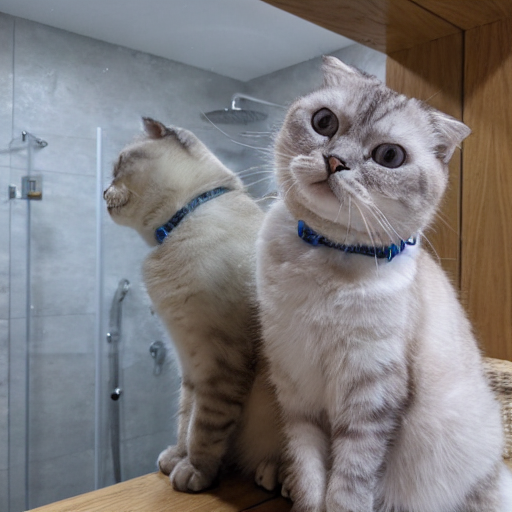

In [4]:
from models import ptp_utils
import torch

image_path = 'projects/prompt_to_prompt/assets/gnochi_mirror.jpeg'
prompt = "a cat sitting next to a mirror"
# using vae to reconstruct the image
image_tensor = ptp_utils.load_512(image_path).to('cuda')
vae = StableDiffuser.vae
with torch.no_grad():
    vae_rec = vae(image_tensor, return_dict=False)[0]
ptp_utils.view_images(ptp_utils.tensor_to_nparray(vae_rec))

#### 2. Use ddim inversion to invert the image

/mnt/wsl/PHYSICALDRIVE4/htr/mmagic/mmagic/models/archs/wrapper.py:149: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  return getattr(self.model, name)
100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


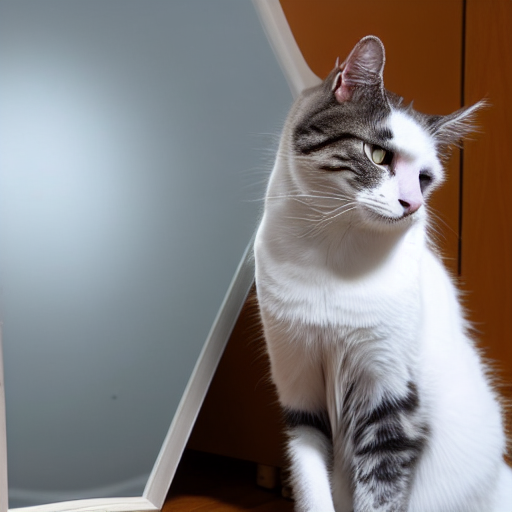

In [5]:
from models.ptp import EmptyControl
from inversions.ddim_inversion import DDIMInversion

ddim_inverter = DDIMInversion(StableDiffuser)
ddim_inverter.init_prompt(prompt)
ddim_latents = ddim_inverter.ddim_inversion(image_tensor)
x_t = ddim_latents[-1]
ddim_rec, _ = ptp_utils.text2image_ldm_stable(StableDiffuser, [prompt], EmptyControl(), latent=x_t)
ptp_utils.view_images(ddim_rec)

#### 2. Use null-text inversion to invert the image
Note null-text inversion uses the same inversion process as ddim inversion but additionally optimizes the **unconditional embedding** to make the result more similar to the original image.

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


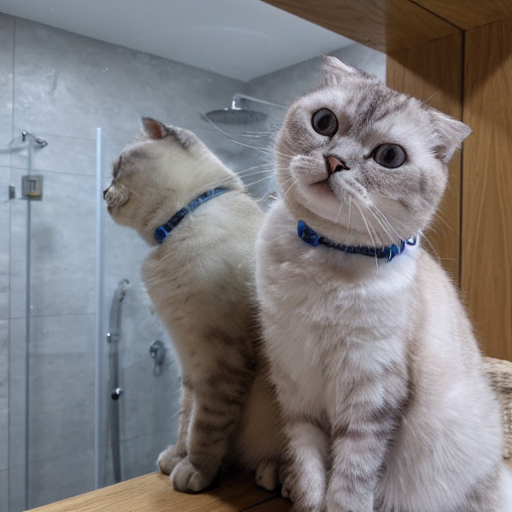

In [6]:
from inversions.null_text_inversion import NullTextInversion
null_inverter = NullTextInversion(StableDiffuser)
null_inverter.init_prompt(prompt)
uncond_embeddings = null_inverter.null_optimization(ddim_latents, num_inner_steps=10, epsilon=1e-5)
null_text_rec, _ = ptp_utils.text2image_ldm_stable(StableDiffuser, [prompt], EmptyControl(), latent=x_t, uncond_embeddings=uncond_embeddings)
ptp_utils.view_images(null_text_rec)

#### 4. Conclusion
Let's put all these results together and it's obvious to see that null-text inversion is better than ddim inversion.

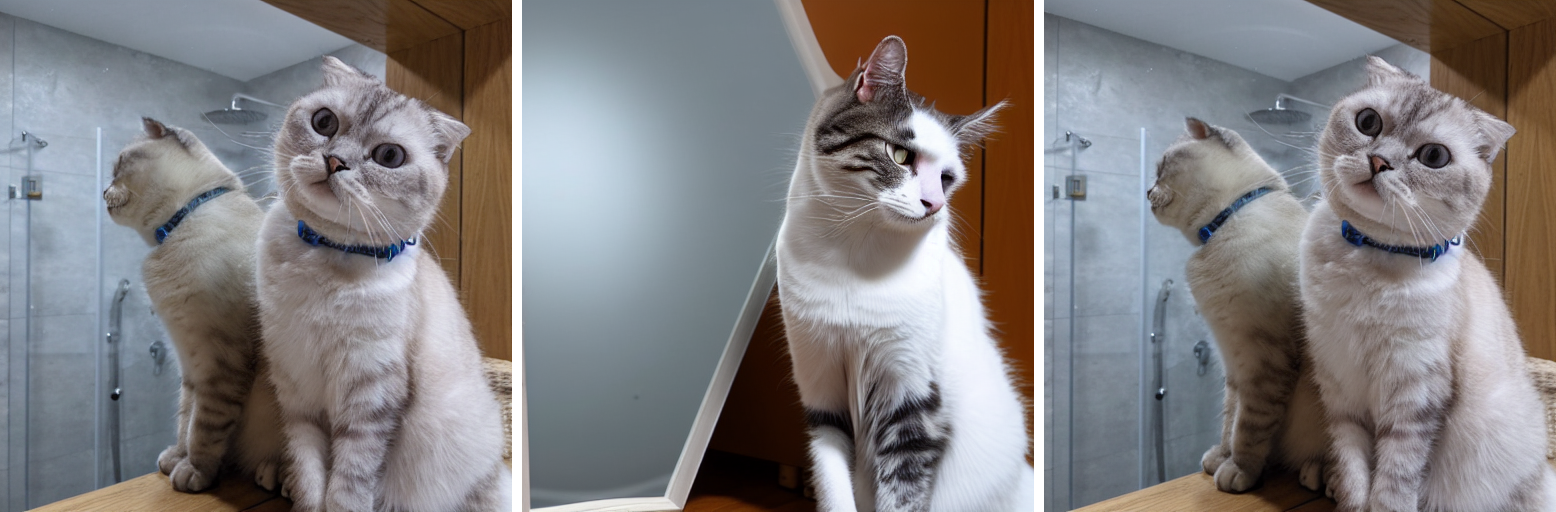

vae reconstruction -> ddim reconstruction -> null text reconstruction


In [7]:
ptp_utils.view_images([ptp_utils.tensor_to_nparray(vae_rec), ddim_rec, null_text_rec])
print("vae reconstruction -> ddim reconstruction -> null text reconstruction")

### Prompt-to-prompt Editing
prompt-to-prompt controls the attention map in diffusion process to edit a user-provided image or generated image. Let's use the example above to see how it works.

Same process as above, we get the noise latent x_t and use new prompt to edit the cat into a dog **while keeping the orther features unchanged**.

In [4]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [7]:
import torch

prompts = ["a cat sitting next to a mirror",
           "a dog sitting next to a mirror"
        ]

cross_replace_steps = {'default_': .8,}
self_replace_steps = .5
blend_word = ((('cat',), ("dog",))) # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
eq_params = {"words": ("dog",), "values": (2,)} # amplify attention to the word "dog" by *2 

from models.ptp import LocalBlend, AttentionReplace
from models.ptp_utils import text2image_ldm_stable

lb = None
lb = LocalBlend(prompts, blend_word, model=StableDiffuser)

controller = AttentionReplace(prompts, 50,
                              cross_replace_steps=cross_replace_steps,
                              self_replace_steps=self_replace_steps, local_blend=lb, model=StableDiffuser)
images, x_t = text2image_ldm_stable(StableDiffuser, prompts, controller, latent=x_t, 
                                    num_inference_steps=50, guidance_scale=7.5, uncond_embeddings=uncond_embeddings)
# make sure to reset all registered attentions to make another inference
controller.reset()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


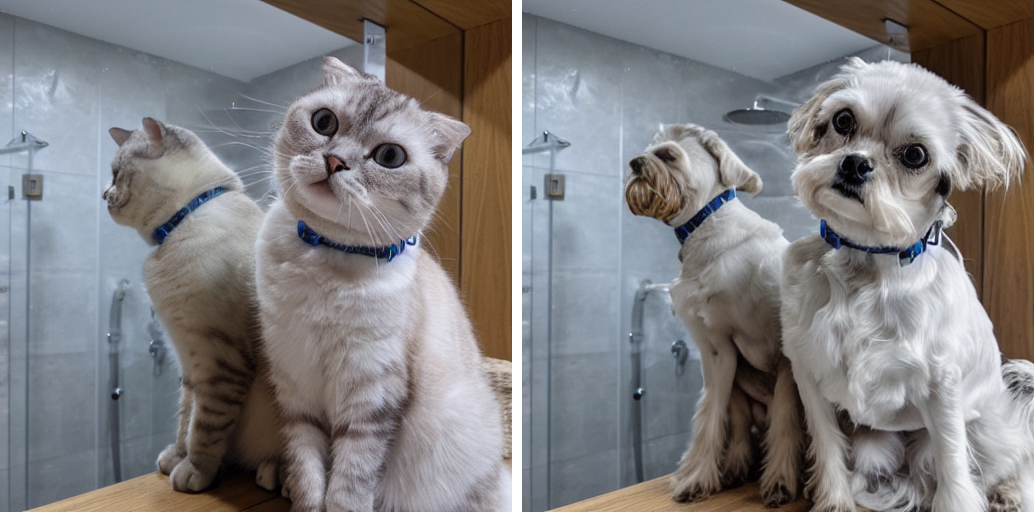

In [8]:
ptp_utils.view_images(images)

Of course ptp can also be used to edit a generated image(no inversion needed).
Three types of attention controller are provided here:
1. AttentionReplace: replace the attention map of the original word with that of new inserted word. (above example)
2. AttentionRefine: extend the prompt with adjective words or something.
3. AttentionReweighting: strengthen or weaken some features' presence in an image

In [27]:
prompts = ["A cartoon of spiderman",
           "A cartoon of ironman"]
import torch
g = torch.Generator().manual_seed(2023616)
lb = LocalBlend(prompts, ("spiderman", "ironman"), model=StableDiffuser)
controller = AttentionReplace(prompts, 50,
                              cross_replace_steps={"default_": 1., "ironman": .2},
                              self_replace_steps=0.4,
                              local_blend=lb, model=StableDiffuser)
images, x_t = text2image_ldm_stable(StableDiffuser, prompts, controller, latent=None, 
                                    num_inference_steps=50, guidance_scale=7.5, uncond_embeddings=None, generator=g)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:12<00:00,  3.85it/s]


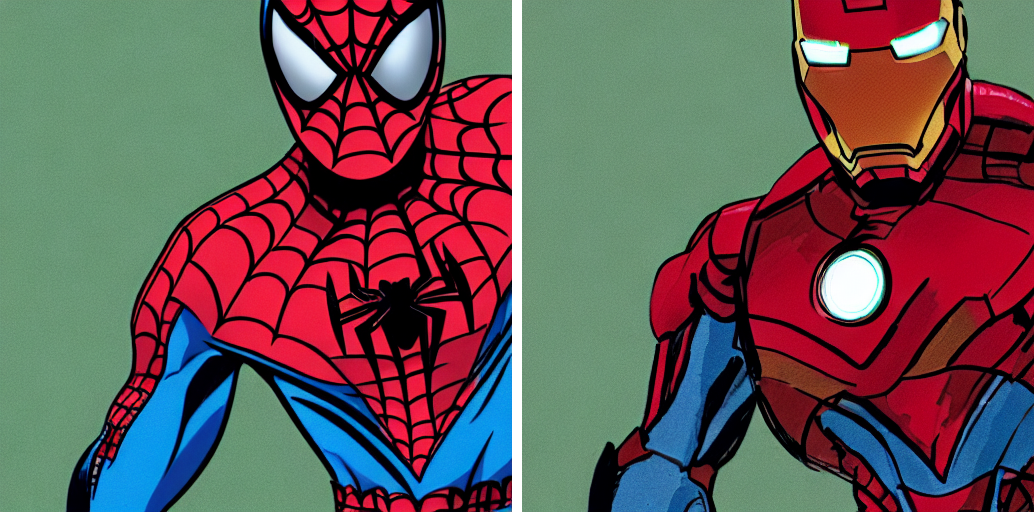

In [28]:
ptp_utils.view_images(images)

100%|██████████| 50/50 [00:13<00:00,  3.84it/s]


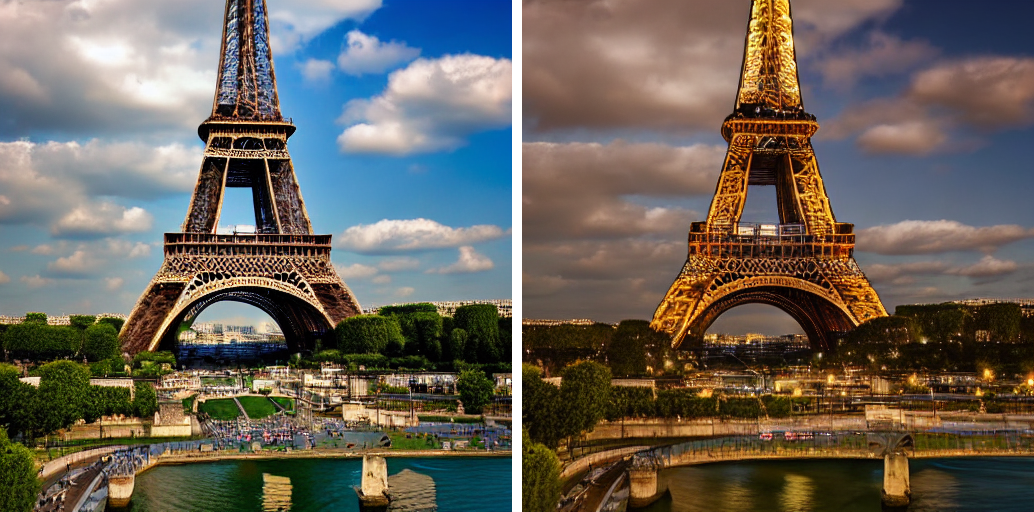

In [46]:
prompts = ["a photo of Eiffel Tower",
           "a photo of Eiffel Tower at night"]
from models.ptp import AttentionRefine
controller = AttentionRefine(prompts, 50, cross_replace_steps=1.0,
                             self_replace_steps=.4, model=StableDiffuser)
images, _ = text2image_ldm_stable(StableDiffuser, prompts, controller, latent=None)
ptp_utils.view_images(images)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:12<00:00,  3.87it/s]


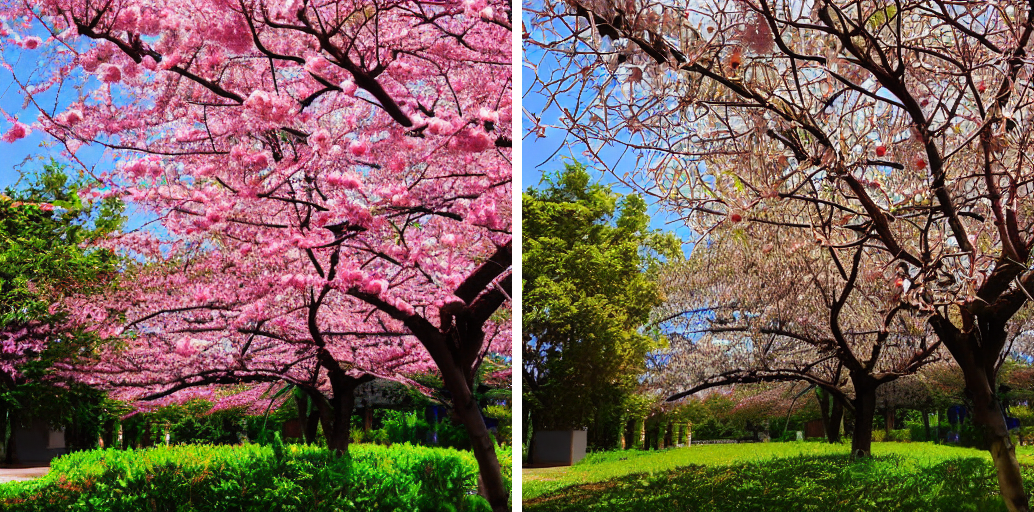

In [78]:
prompts = ["a blossom sakura tree"] * 2

from models.ptp import AttentionReweight, get_equalizer
### pay 3 times more attention to the word "roses"
equalizer = get_equalizer(prompts[1], ("blossom",), (-3,), StableDiffuser.tokenizer)
controller = AttentionReweight(prompts, 50, cross_replace_steps=.8,
                               self_replace_steps=.4,
                               equalizer=equalizer, model=StableDiffuser)
images, _ = text2image_ldm_stable(StableDiffuser, prompts, controller, latent=None)
ptp_utils.view_images(images)